<h1><font color='blue'>YELP RESTAURANT RECOMMENDATION ENGINE</font></h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from surprise import Reader
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import train_test_split as tts
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise import BaselineOnly
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from numpy import count_nonzero
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import data that was previously wrangled 
psql_data = pd.DataFrame(pd.read_csv(r'psql_data.csv', sep = "|", index_col=0, dtype={'postal_code': object}))

In [3]:
# Limit the number of restaurant categories
selected_list = ['Italian', 'Japanese','Mexican', 'Burgers']

In [4]:
# Eliminate restaurant categories not in selected list & add counter for records with selected categories
category_list = list(psql_data.columns.values)[19:]
elimination_list = set(category_list) - set(selected_list)
psql_data = psql_data.drop(elimination_list, axis=1)
psql_data['Category_Count'] =  psql_data['Italian'] + psql_data['Japanese'] + psql_data['Mexican'] + psql_data['Burgers']

In [5]:
# Select one metropolitan area --> Metro Phoenix & chose randomly sample of 25,000 users
area = 'AZ'
users = psql_data['user_id'][psql_data['state_']==area].drop_duplicates().sample(n=25000, replace=False, random_state=40)
subset_data = psql_data[(psql_data['Category_Count'] > 0) & (psql_data['user_id'].isin(users)) & (psql_data['state_']==area)]
len(subset_data)

32288

In [6]:
# Train, test and split
X = subset_data
y = subset_data['user_stars']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)
subset_data.head(2)

,date,review_id,user_id,user_stars,categories,business_id,business_name,review_count,business_stars,address,...,longitude,hours,is_open,friend_count,order_rank,Burgers,Italian,Japanese,Mexican,Category_Count
3200,2009-08-18 03:32:09,nByAeEziH3S7YD2_LRU4BA,5YmebJqh7Wd-g3Bh4-vvmA,4,"Food, Burgers, Restaurants, Fast Food, Ice Cre...",-_v2it0tjfDriFqN-FGpIg,Sonic Drive-In,33,3.0,15471 W Bell Rd,...,-112.392761,"{'Monday': '6:0-23:0', 'Tuesday': '6:0-23:0', ...",1,37,2,1,0,0,0,1
3214,2014-07-03 02:44:40,_tefG6MUxGDjSAUWTKhy6g,fXKLqo1D6E6liLCp5HuWkg,1,"Food, Burgers, Restaurants, Fast Food, Ice Cre...",-_v2it0tjfDriFqN-FGpIg,Sonic Drive-In,33,3.0,15471 W Bell Rd,...,-112.392761,"{'Monday': '6:0-23:0', 'Tuesday': '6:0-23:0', ...",1,1,16,1,0,0,0,1


In [7]:
# Create matrix for user-restaurants
def matrix(data, area, user_list):
    '''Matrix of user and restaurant star ratings'''
    matrix_restaurants = data[(data['state_']==area) & (data['user_id'].isin(user_list) & (data['review_count'] > 0))].pivot_table(index='user_id', columns='business_id', values='user_stars').fillna(0)
    return matrix_restaurants
matrix_restaurants = matrix(X_train, area, users)

In [8]:
# Sparseness of matrix
1 - (count_nonzero(np.array(matrix_restaurants))/(matrix_restaurants.shape[1] * matrix_restaurants.shape[0]))

0.9991593567225355

In [9]:
# Create similarity matrix between users
similarity = cosine_similarity(matrix_restaurants)
similarity = pd.DataFrame(similarity, index=matrix_restaurants.index, columns=matrix_restaurants.index)
similarity

user_id,--gsZ16vkDVFD5uSuUFBFw,--rms0ED1Ok7OFqZILWiAg,--xazodgk012WDgg9sOkdg,-0Jra7uIavkcu4Dh16_ouw,-0K2ZWX8tDH1mrzNXNoiqg,-0McWEfx_Kk7LGa1oxv08w,-0Wd9AHoInqLBkW7bIS4zw,-29KHRxPgoigsUO-lw1y6g,-2IvqrJdcoUTW143G3XBDg,-2_lWE1UdAIq1u9ttyTTnA,...,zv0GOvbgMLAVSHWsLJUMvQ,zv25xxIX0HblNN8sJDt19A,zv3uF3mhC2JROTWF_994Xw,zvLmXVXkbDcXWrM3D6TUwQ,zvm5CnSu8X77P5WvjeXV_g,zwazb6slpTTCLtZNsFdcJg,zxGDhtnvKYFsv0IXRUEbgQ,zyI_EO45CxVVrm-DtBXOJA,zyo_PBKqJ2nDLPnM_nR48Q,zzk6L1hPy116OGyapMhodA
user_id,,,,,,,,,,,,,,,,,,,,,
--gsZ16vkDVFD5uSuUFBFw,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--rms0ED1Ok7OFqZILWiAg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--xazodgk012WDgg9sOkdg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0Jra7uIavkcu4Dh16_ouw,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0K2ZWX8tDH1mrzNXNoiqg,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zwazb6slpTTCLtZNsFdcJg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
zxGDhtnvKYFsv0IXRUEbgQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
zyI_EO45CxVVrm-DtBXOJA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [10]:
# Custom weighted average algorithm
def calc_star_values(business_id, user_id):
    '''Calculations for predictions of restaurant star ratings based on weighted average methodology'''
    if user_id in list(X_train['user_id']):
        if business_id in matrix_restaurants:
            cosine_scores = similarity[user_id] # cosine similarity by user
            ratings_scores = matrix_restaurants[business_id] # star ratings for specific restaurant
            index_not_rated = ratings_scores[ratings_scores==0].index # businesses without ratings for user
            ratings_scores = ratings_scores[ratings_scores!=0] # records with ratings
            cosine_scores = cosine_scores.drop(index_not_rated) # cosine scores of only records with ratings
            if cosine_scores.sum() > 0:
                stars_prediction = np.dot(ratings_scores, cosine_scores)/cosine_scores.sum() #prediction >>> weighted average
            else:
                return -1 # -1 assigned to records without data
        else:
            return -1
    else:
        return -1
    return stars_prediction

In [11]:
# Fuction for classification report with rounding of predicted values
def precision_recall(actual_stars, predicted_stars):
    '''Round prediction values for precision recall classification report'''
    predicted_stars = [round(x) for x in predicted_stars]
    print(classification_report(actual_stars, predicted_stars)) 

In [12]:
# Find predictions using custom weighted average algorithm
predicted_ratings = []
true_ratings = []
for i in range(len(y_test)):
    if calc_star_values(X_test['business_id'].iloc[i], X_test['user_id'].iloc[i])!=-1:
        predicted_ratings.append(round(calc_star_values(X_test['business_id'].iloc[i], X_test['user_id'].iloc[i])))
        true_ratings.append(y_test.iloc[i])
predicted_ratings = np.array(predicted_ratings)
true_ratings = np.array(true_ratings)


In [13]:
# Measure results from cusom weighted average algorithm
print('Weighted Average results')
precision_recall(true_ratings, predicted_ratings)

Weighted Average results
              precision    recall  f1-score   support

           1       0.27      0.08      0.13       273
           2       0.15      0.13      0.14       290
           3       0.16      0.22      0.18       467
           4       0.29      0.48      0.36       927
           5       0.51      0.28      0.36      1306

    accuracy                           0.30      3263
   macro avg       0.27      0.24      0.24      3263
weighted avg       0.34      0.30      0.30      3263



In [14]:
# Set up to use python surprise package
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(subset_data[['user_id', 'business_id', 'user_stars']], reader)

In [15]:
# Train, test, split for surprise
trainset, testset = tts(data, test_size=0.25, random_state=40)

In [16]:
# Predict, fit, measure for surprise algorithms
def surprise_algo(algorithm):
    '''Model surprise algorithm using trainset and testset'''
    algo = algorithm
    predictions = algo.fit(trainset).test(testset)
    algo_df = pd.DataFrame(predictions)
    precision, recall, f1, supt = precision_recall_fscore_support(algo_df['r_ui'], round(algo_df['est']), average='weighted')
    return predictions, algo_df, precision, recall

In [17]:
# Run surprise prediction algorithms - BaselineOnly, Matrix Factorization and KNNBasic
print('BaselineOnly() results')
bl_predictions, bl_df, precision, recall = surprise_algo(BaselineOnly())
print('Precision:', precision, 'Recall:', recall, '\n')

print('Matrix Factorization SVD results')
svd_predictions, svd_df, precision, recall = surprise_algo(SVD(random_state=40))
print('Precision:', precision, 'Recall:', recall, '\n')

print('KNNBasic results')
sim_options = {'name': 'cosine','user_based': False}
knn_predictions, knn_df, precision, recall = surprise_algo(KNNBasic(sim_options=sim_options))
print('Precision:', precision, 'Recall:', recall, '\n')

BaselineOnly() results
Estimating biases using als...
Precision: 0.44282714658803124 Recall: 0.23550545094152625 

Matrix Factorization SVD results
Precision: 0.5471169296633428 Recall: 0.24801783944499503 

KNNBasic results
Computing the cosine similarity matrix...
Done computing similarity matrix.
Precision: 0.3774736572864383 Recall: 0.2651139742319128 



In [18]:
# Tune parameters for the surprise matrix factorization SVD algorithm
t0 = time.time()

factors = [3, 12, 50, 100]
epochs =[5, 10, 20, 40]
mean = [0, .05, .10, .15]
std_dev = [0, .05, .10, .15]
lr = [0.001, 0.003, 0.005,0.007]
reg = [0.01, 0.02, 0.03, 0.04]
max_precision = 0
dict = {}
for n_factors in factors:
    for n_epochs in epochs:
        for init_mean in mean:
            for init_std_dev in std_dev:
                for lr_all in lr:
                    for reg_all in reg:
                        svd_predictions, svd_df, precision, recall = surprise_algo(SVD(
                            n_factors=n_factors, n_epochs=n_epochs, init_mean=init_mean, init_std_dev=init_std_dev,
                            lr_all=lr_all, reg_all=reg_all, random_state=40))
                        if precision > max_precision:
                            max_precision = precision
                            dict = {'n_factors': n_factors, 'n_epochs': n_epochs, 'init_mean': init_mean, 'init_std_dev': init_std_dev,
                                    'lr_all': lr_all, 'reg_all': reg_all}

t1 = time.time()
print(round((t1 - t0)/60,2), 'minutes to execute code.')

69.83 minutes to execute code.


In [19]:
# Summarize the results of hyperparameter tuning
print(dict)
print(max_precision)

{'n_factors': 100, 'n_epochs': 10, 'init_mean': 0, 'init_std_dev': 0.1, 'lr_all': 0.007, 'reg_all': 0.04}
0.5590948086964709


In [20]:
# Rerun surprise matrix factorization SVD using tuned parameters
svd_predictions, svd_df, precision, recall = surprise_algo(SVD(n_factors=dict.get('n_factors'), n_epochs=dict.get('n_epochs'), 
                                                                   init_mean=dict.get('init_mean'), init_std_dev=dict.get('init_std_dev'),
                                                                   lr_all=dict.get('lr_all'), reg_all=dict.get('reg_all'), random_state=40))
print('Matrix Factorization SVD tuned results')
print('Precision:', precision)
print('Recall:', recall)    

Matrix Factorization SVD tuned results
Precision: 0.5590948086964709
Recall: 0.24194747274529238


In [21]:
# tuned matrix factorization SVD classification report
precision_recall(svd_df['r_ui'], svd_df['est'])

              precision    recall  f1-score   support

         1.0       1.00      0.00      0.00      1103
         2.0       0.20      0.01      0.01       739
         3.0       0.17      0.30      0.21       916
         4.0       0.24      0.80      0.37      1884
         5.0       0.77      0.05      0.09      3430

    accuracy                           0.24      8072
   macro avg       0.48      0.23      0.14      8072
weighted avg       0.56      0.24      0.15      8072



In [22]:
# Tuned matrix factorization SVD confusion matrix
confusion_matrix(svd_df['r_ui'], round(svd_df['est']))

array([[   2,   15,  426,  659,    1],
       [   0,    5,  251,  474,    9],
       [   0,    3,  279,  626,    8],
       [   0,    2,  348, 1504,   30],
       [   0,    0,  380, 2887,  163]], dtype=int64)

In [23]:
# Convert from multi classification to binary classification
def change_to_binary(true, predicted, threshold):
    '''Change ratings 1-5 to 0 & 1 based on specific threshold'''
    true = [1 if x >= 4 else 0 for x in true]
    predicted = [1 if x >= threshold else 0 for x in predicted]
    return true, predicted
# loop through and different thresholds in order to populate values for precision recall curve
precision_values = []
recall_values = []
for i in [1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5]:
    true_values, predicted_values = change_to_binary(svd_df['r_ui'], svd_df['est'], i)
    precision, recall, f1, supt = precision_recall_fscore_support(true_values, predicted_values, average='binary')
    precision_values.append(precision)
    recall_values.append(recall)
    print('Threshold = ', i)
    print('Precision:', precision)
    print('Recall:', recall, '\n')

Threshold =  1
Precision: 0.6583250743310208
Recall: 1.0 

Threshold =  1.25
Precision: 0.6583250743310208
Recall: 1.0 

Threshold =  1.5
Precision: 0.6584882280049567
Recall: 1.0 

Threshold =  1.75
Precision: 0.6584882280049567
Recall: 1.0 

Threshold =  2
Precision: 0.6584882280049567
Recall: 1.0 

Threshold =  2.25
Precision: 0.6586091483822982
Recall: 0.9998118178396688 

Threshold =  2.5
Precision: 0.6602858918582971
Recall: 0.9996236356793377 

Threshold =  3
Precision: 0.6715384615384615
Recall: 0.9856981558148288 

Threshold =  3.25
Precision: 0.6880809185347184
Recall: 0.9473089951072639 

Threshold =  3.5
Precision: 0.7206414085835561
Recall: 0.8626270229582236 

Threshold =  3.75
Precision: 0.7752613240418118
Recall: 0.6699284907790741 

Threshold =  4
Precision: 0.8301519283209973
Recall: 0.4010161836657885 

Threshold =  4.25
Precision: 0.8783018867924528
Recall: 0.17519759126834777 

Threshold =  4.5
Precision: 0.9146919431279621
Recall: 0.03631915694392172 

Threshold =

(0, 1.05)

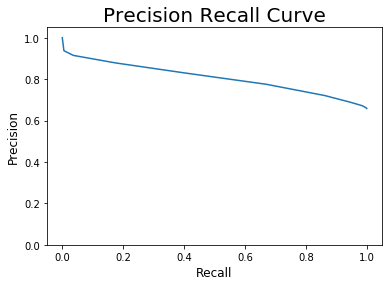

In [24]:
# Plot precision recall curve
sns.lineplot(x=recall_values, y=precision_values) 
plt.title('Precision Recall Curve', fontsize=20)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.subplots_adjust(hspace=0.4)
plt.ylim(0,1.05)

In [25]:
# Calculate area under the curve
prc_auc = auc(recall_values, precision_values)
print('Area under the precision recall curve:', prc_auc)

Area under the precision recall curve: 0.806167636666187


In [26]:
# Run algorithm for matrix factorization SVD with threshold of 3.5
true_values, predicted_values = change_to_binary(svd_df['r_ui'], svd_df['est'], 3.5)

In [27]:
# Matrix factorization SVD confusion matrix with threshold of 3.5
precision_recall(true_values, predicted_values)

              precision    recall  f1-score   support

           0       0.57      0.36      0.44      2758
           1       0.72      0.86      0.79      5314

    accuracy                           0.69      8072
   macro avg       0.65      0.61      0.61      8072
weighted avg       0.67      0.69      0.67      8072



In [28]:
# Confusion matrix for matrix factorization SVD with threshold of 3.5
confusion_matrix(true_values, predicted_values)

array([[ 981, 1777],
       [ 730, 4584]], dtype=int64)

In [29]:
# Add predicted and true value columns to DataFrame & merge to add business name and count
svd_df['true_value'] = true_values
svd_df['predicted_value'] = predicted_values
svd_df = pd.merge(svd_df, subset_data[['business_id', 'business_name']].drop_duplicates(), how='left', 
                  left_on='iid', right_on='business_id')
svd_df = pd.merge(svd_df, svd_df['uid'].value_counts(), left_on='uid', right_on=svd_df['uid'].value_counts().index)
svd_df.columns.values[10] = 'uid_count'
reco_df = svd_df[svd_df['predicted_value']==1].sort_values(by=['uid_count', 'uid', 'est'], 
                                                          ascending=[False, True, False]).drop(['details',
                                                                                                'business_id', 'uid_x'],axis=1)

In [30]:
# Recommendations
reco_df = pd.DataFrame({'user_id': reco_df['uid'], 'business_id': reco_df['iid'] , 'business_name': reco_df['business_name'], 
           'predicted_value': reco_df['predicted_value'], 'true_value': reco_df['true_value'], 'predicted_rating': reco_df['est'],
                        'true_rating': reco_df['r_ui']})
reco_df.head(10)

,user_id,business_id,business_name,predicted_value,true_value,predicted_rating,true_rating
282,iDlkZO2iILS8Jwfdy7DP9A,oMBNvB6tHlwW3UwGBYqljw,Blue Fin,1,1,4.521318,5.0
266,iDlkZO2iILS8Jwfdy7DP9A,cTZmf7B-4yciMc1WKiCVOA,Welcome Diner,1,1,4.303440,5.0
290,iDlkZO2iILS8Jwfdy7DP9A,DaVTuhzi6EgWStb2eAjNjA,Presidio Cocina Mexicana,1,1,4.170000,5.0
303,iDlkZO2iILS8Jwfdy7DP9A,Tw3miGKZHtmxmaQZIYFRrA,Federal Pizza,1,1,4.157582,5.0
288,iDlkZO2iILS8Jwfdy7DP9A,LtNgP4FqXp5nMFOHErK8cw,Yen Sushi & Sake Bar,1,1,4.039577,4.0
278,iDlkZO2iILS8Jwfdy7DP9A,qUPUCcBbn-ugXFSItXLmGw,Akai Hana Sushi & Grill,1,1,4.001893,4.0
268,iDlkZO2iILS8Jwfdy7DP9A,wa8QgXQu1ZxwPgdRl9lYlg,Tampopo Ramen,1,0,4.001597,3.0
299,iDlkZO2iILS8Jwfdy7DP9A,CUivTcULsu5MJIYYNVm1zw,Hana Japanese Eatery,1,1,3.992266,4.0
281,iDlkZO2iILS8Jwfdy7DP9A,eS29S_06lvsDW04wVrIVxg,Barrio CafÃ©,1,0,3.958837,3.0
314,iDlkZO2iILS8Jwfdy7DP9A,89uU51kOiQXbJHVA3C6XMQ,The Original Carolina's Mexican Food,1,1,3.949200,4.0
